In [80]:
#Import Neccasery Packages
import tqdm as notebook_tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance



In [81]:
# Read the original CSV files (only once)
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')

In [82]:
# Copy the original data to DataFrames for manipulation
train = train_original.copy()
test = test_original.copy()

In [83]:
#Train set manipulation for train 

  # Drop 'Name' and 'Ticket' columns from train
train = pd.get_dummies(train, columns=['Sex', 'Embarked', 'Pclass'], dtype=int)  # One-hot encoding
train['Age'] = train['Age'].fillna(train['Age'].mean()).astype(int)  # Fill missing Age with mean and convert to int
train['Cabin'] = train['Cabin'].fillna(0)  # Fill missing Cabin with 0
train['Fare'] = train['Fare'].fillna(train['Fare'].median())  # Fill missing Fare with median
train['HasCabin'] = train['Cabin'].apply(lambda x: 1 if isinstance(x, str) and len(x) > 0 else 0)  # Create 'HasCabin' column
train['Age'] = train['Age'].astype(int)  # Ensure Age is an integer type

In [84]:
#Test set manipulation

test = pd.get_dummies(test, columns=['Sex', 'Embarked', 'Pclass'], dtype=int)
test['Age'] = test['Age'].fillna(test['Age'].mean()).astype(int)  
test['Cabin'] = test['Cabin'].fillna(0)
test['Fare'] = test['Fare'].fillna(test['Fare'].median())  # 'Fare' may have a different distribution
test['HasCabin'] = test['Cabin'].apply(lambda x: 1 if isinstance(x, str) and len(x) > 0 else 0)
test['Age'] = test['Age'].astype(int)

train['Family_Size'] = train['SibSp'] + train['Parch'] +1 
test['Family_Size'] = test['SibSp'] + test['Parch'] +1 
train['Fare_Per_Person'] = train.apply(lambda x: x['Fare'] / x['Family_Size'] if x['Family_Size'] > 0 else x['Fare'], axis=1)
test['Fare_Per_Person'] = test.apply(lambda x: x['Fare'] / x['Family_Size'] if x['Family_Size'] > 0 else x['Fare'], axis=1)

In [85]:
#FEATURE ENGINEERING, PUTTING 3 CATEGORIES OF FARES#

#Drop the rows with nrgative fare values 
train = train[train['Fare'] >= 0]
test = test[test['Fare'] >=0]


#Ticket Frequency
train['Ticket_Frequency'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Ticket_Frequency'] = test.groupby('Ticket')['Ticket'].transform('count')

# Calculate Fare percentiles
min_fare = train['Fare'].min()
max_fare = train['Fare'].max()

# Define bins based on Fare's min, max, and percentiles
bins = [min_fare, train['Fare'].quantile(0.33), train['Fare'].quantile(0.66), max_fare]

# Define labels for the bins (low, medium, high)
labels = ['Low Fare', 'Medium Fare', 'High Fare']

# Create a new column for Fare categories
train['Fare_Category'] = pd.cut(train['Fare'], bins=bins, labels=labels, include_lowest=True)

# If you need the same for the test data
test['Fare_Category'] = pd.cut(test['Fare'], bins=bins, labels=labels, include_lowest=True)
train = pd.get_dummies(train, columns=['Fare_Category'], dtype=int)  # One-hot encoding
test= pd.get_dummies(test, columns=['Fare_Category'], dtype=int)  # One-hot encoding

train['Is_Alone'] = (train['Family_Size'] == 0).astype(int)
test['Is_Alone'] = (test['Family_Size'] == 0).astype(int)

#Extract Titles from names# 
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Col', 'Major', 'Capt', 'Sir', 'Lady', 'Countess', 'Jonkheer', 'Don', 'Dona']
test 
train

train['HasTitle'] = train['Name'].apply(lambda x: 1 if any(title in x for title in titles) else 0)
test['HasTitle'] = test['Name'].apply(lambda x: 1 if any(title in x for title in titles) else 0)

#Create age groups 
bins = [0, 12, 20, 30, 50, 80, 100]  
labels = ['0-12', '12-20', '20-30', '30-50', '50-80', '80-100']  
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)
test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels, right=False)
train= pd.get_dummies(train, columns=['AgeGroup'], dtype = int)
test= pd.get_dummies(test, columns=['AgeGroup'], dtype = int)

#Create Family size Categories 

def family_size_category(family_size): 
    if family_size == 1:
        return 'Alone'
    elif family_size in [2, 3, 4]:
        return 'Small'
    elif family_size in [5, 6]:
        return 'Medium'
    elif family_size in [7, 8, 11]:
        return 'Large'

train['Family_Size_Label'] = train['Family_Size'].apply(family_size_category)
test['Family_Size_Label'] = test['Family_Size'].apply(family_size_category)
train = pd.get_dummies(train, columns = ['Family_Size_Label'], dtype= int)
test = pd.get_dummies(test, columns = ['Family_Size_Label'], dtype= int)
    


train['Fare'] = np.log1p(train['Fare'])
test['Fare'] = np.log1p(test['Fare'])

train = train.drop(columns=['Name', 'Age','Ticket'])
test = test.drop(columns=['Name', 'Age', 'Ticket'])


In [86]:
#TRAIN / TEST MODELS#

# Ensure that the test columns match the train columns
test = test.reindex(columns=train.columns, fill_value=0)

# Split the data into features (X) and target (y)
X = train.drop(columns=['Survived', 'Cabin', 'Fare', 'PassengerId'])
y = train['Survived']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:24:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Best Score: 0.8427117682516044


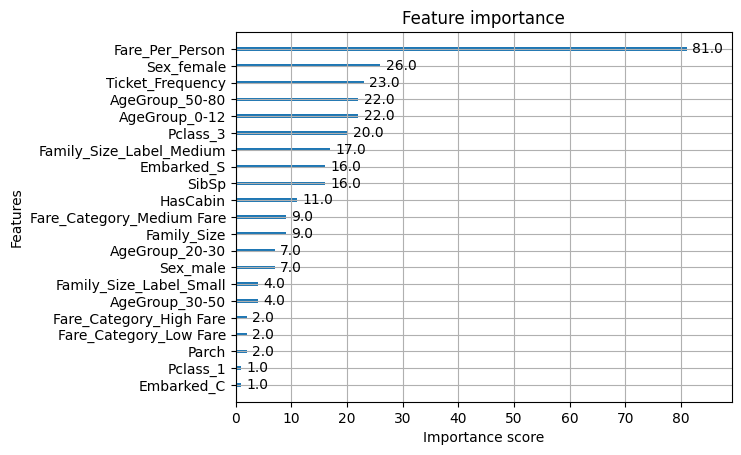

In [96]:
# Define the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Hyperparameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.154, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

# Plot feature importance
plot_importance(best_model)
plt.show()



In [88]:
# Evaluate model performance on the validation set
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Prepare the test set for prediction
X_test = test.drop(columns=['Survived', 'Cabin', 'Fare', 'PassengerId'])

# Make predictions on the test set
test_predictions = best_model.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})

# Save submission file
submission.to_csv('submission1.csv', index=False)

Accuracy: 0.7877094972067039
Confusion Matrix:
 [[96 14]
 [24 45]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



In [89]:
# Now, define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the validation set (use y_val, not y_test)
rf_y_pred = rf_model.predict(X_val)

# Accuracy for the Random Forest Model
accuracy_rf = accuracy_score(y_val, rf_y_pred)
print(f'Random Forest Model Accuracy: {accuracy_rf:.2f}')

Random Forest Model Accuracy: 0.74


In [90]:

ensemble = VotingClassifier(estimators=[
    ('xgb', best_model),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=500))
], voting='soft')

ensemble.fit(X_train, y_train)
print("Ensemble Accuracy:", accuracy_score(y_val, ensemble.predict(X_val)))

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:21:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.8044692737430168


In [91]:
train 


,PassengerId,Survived,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,AgeGroup_0-12,AgeGroup_12-20,AgeGroup_20-30,AgeGroup_30-50,AgeGroup_50-80,AgeGroup_80-100,Family_Size_Label_Alone,Family_Size_Label_Large,Family_Size_Label_Medium,Family_Size_Label_Small
0,1,0,1,0,2.110213,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,1,1,0,4.280593,C85,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,3,1,0,0,2.188856,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,4,1,1,0,3.990834,C123,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,5,0,0,0,2.202765,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0,0,2.639057,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
887,888,1,0,0,3.433987,B42,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
888,889,0,1,2,3.196630,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
889,890,1,0,0,3.433987,C148,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0


In [92]:
(train['Fare'] < 0).sum()


0

In [93]:
plot_importance(model)
plt.show()

NotFittedError: need to call fit or load_model beforehand

In [94]:
# Get feature importance
importances = rf_model.feature_importances_

# Plot feature importance
plt.barh(train.drop(columns=['target_column']).columns, importances)
plt.show()

KeyError: "['target_column'] not found in axis"

In [ ]:
# Use SHAP to explain the model
explainer = shap.TreeExplainer(model)  # Use different explainers for other models
shap_values = explainer.shap_values(train.drop(columns=['target_column']))

# Plot the SHAP summary
shap.summary_plot(shap_values, train.drop(columns=['target_column']))